Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('float_format', '{:.3f}'.format)

## Исходные данные

In [3]:
g = 9.81    # ускорения свободного падения

Описание геометрии

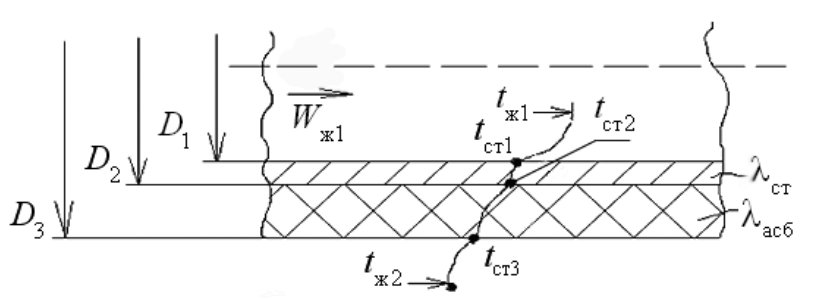

In [4]:
D1 = 0.045           # внутрениий диаметр трубы
D2 = 0.055           # наружный диаметр трубы
D3 = 1               # наружный диаметр изоляции
Wfl = 0.775          # скорость воды м/с
tf1 = 105            # температура воды
tf2 = 11             # температура воздуха
tw3 = 36             # температуры внешней поверхности изолированной трубы
kw = 50              # теплопроводность стали
ka = 0.106           # теплопроводность асбеста

Физические свойства воды и воздуха при данной температуре

- Воздух

In [5]:
# Формула Сазерленда вязкость
def visc2air (t):
    T0 = 273.15 
    T = t+T0
    mu0 = 1.716e-5
    Sm = 110.4
    mu = mu0*(T0+Sm)/(T+Sm)*(T/T0)**(3/2)
    return mu

In [6]:
# Плотность 
def dens2air (t):
    T = t + 273.15
    P = 101325
    Rm = 287.4
    rho = P/Rm/T
    return rho

In [7]:
# Теплопроводность
def k2air (t):
    T0 = 273.15
    T = t + T0
    Sk = 202.2
    k0 = 2.404e-2
    k = k0*(T0+Sk)/(T+Sk)*(T/T0)**(3/2) 
    return k

In [8]:
# Теплоемкость
def cp2air (t):
    Cp = (1.0005+(1.1904e-4)*t)*1000
    return Cp    

In [9]:
def betta (t):
    T = t + 273.15
    b = 1 / T
    return b  

- Вода (https://holzmann-cfd.com/community/blog-and-tools/cae-blog/thermophysical-properties-water) Я нашел только при температуре до $90 ^0C$

In [10]:
# Формула вязкости
def visc2water (t):
    if t > 90:
        t = 90
    T = 273.15 + t
    A = -2.80572e-9
    B = 2.90283e-6 
    C = -0.00100532
    D = 0.116947
    mu = A*T**3 + B*T**2 + C*T + D
    return mu

In [11]:
# Формула плотность
def dens2water (t):
    if t > 90:
        t = 90
    T = 273.15 + t
    A = -0.00365471 
    B = 1.93017 
    C = 746.025
    rho = A*T**2 + B*T + C
    return rho

In [12]:
# Формула теплопроводности
def k2water (t):
    if t > 90:
        t = 90
    T = 273.15 + t
    A = -9.29827e-6  
    B = 0.0071857 
    C = -0.710696
    k = A*T**2 + B*T + C
    return k

In [13]:
# Формула теплоемкости
def cp2water (t):
    if t > 90:
        t = 90
    T = 273.15 + t
    A = -0.000127063
    B = 0.13736 
    C = -48.6714
    D = 9850.69
    Cp = A*T**3 + B*T**2 + C*T + D
    return Cp

## Параметры теплообмена

### В трубе

 - Число Рейнольдса

In [14]:
Ref = Wfl*D1*dens2water(tf1)/visc2water(tf1)
print('Значение числа Рейнольдса в трубе:', Ref//1)

Значение числа Рейнольдса в трубе: 107115.0


**Режим течения турбулентный (Re> 10000 )**

 - Число Прандтля

In [15]:
Prf1 = visc2water(tf1)*cp2water(tf1)/k2water (tf1)
print(f"Значение числа Прандтля для воды: {Prf1:.3}")

Значение числа Прандтля для воды: 1.96


### С внешней стороны трубы

In [16]:
Prf2 = visc2air(tf2)*cp2air(tf2)/k2air (tf2)
print(f"Значение числа Прандтля для воздуха: {Prf2:.2}")

Значение числа Прандтля для воздуха: 0.71


## Итерационный расчет

Начальное приближение

In [17]:
tw1 = tf1
D3 = 2*D2
dT = 1

Основной цикл

In [18]:
it = 0 
iteration_tab = []
while abs(dT) >= 0.1:
    print(f"___________________________Итерация_ №_{it+1}____________________________________")
    # Интенсивность теплоотдачи (Число Нуссельта, коэффициент теплоотдачи) от жидкости
    Nuf1 = 0.023*Ref**0.8*Prf1*(1./3)*(visc2water(tf1)/visc2air(tf1))**0.14
    print(f"Значение числа Нуссельта в трубе: {Nuf1//1}")
    hf1 = Nuf1*k2water (tf1)/D1
    print(f"Значение коэффициента теплоотдачи в трубе: {hf1//1} [W/m2/K]")
    # Интенсивность теплоотдачи (Число Грасгофа, Нуссельта, коэффициент теплоотдачи) воздух
    Grf2 = g*betta(tf2)*(tw3 - tf2)*(dens2air(tf2)/visc2air(tf2))**2*D3**3
    print('Значение числа Грасгофа:', Grf2//1)
    Nuf2 = 0.5*(Grf2*Prf2)**0.25
    print('Значение числа Нуссельта c внешней стороны трубы:', Nuf2//1)
    hf2 = Nuf2*k2air(tf2)/D3
    print(f"Значение коэффициента теплоотдачи в трубе: {hf2//1} [W/m2/K]")
    # Плотность теплового потока в трубе с изоляцией
    Rk1 = 1/2/kw*np.log(D2/D1)
    Rk2 = 1/2/ka*np.log(D3/D2)
    Rh1 = 1/ hf1 /D1
    Rh2 = 1/ hf2 /D3
    ql = np.pi*(tf1-tf2)/(Rh1+Rh2+Rk1+Rk2)
    print(f"Значение плотности теплового потока: {ql//1} [W/m2]")
    # Температуры внешней стенки
    tw3iter = tf2 + ql* Rh2/np.pi
    print(f"Температура внешней стенки: {tw3iter//1} [K]")
    # Ошибка определения температуры внешней стенки
    dT = (tw3 - tw3iter)
    print(f"Ошибка определения температуры стенки: {dT} [K]")
    iteration_tab.append ([Nuf1, hf1, Grf2, Nuf2, hf2, ql, tw3iter, dT, D3])
    # Новые приближения по диаметру изоляции и температуры внутренней стенки
    it += 1
    tw1 = tf1 - ql* Rh1/np.pi
    D3 = ql/ hf2/np.pi / (tw3- tf2)    

___________________________Итерация_ №_1____________________________________
Значение числа Нуссельта в трубе: 230.0
Значение коэффициента теплоотдачи в трубе: 3451.0 [W/m2/K]
Значение числа Грасгофа: 5645338.0
Значение числа Нуссельта c внешней стороны трубы: 22.0
Значение коэффициента теплоотдачи в трубе: 5.0 [W/m2/K]
Значение плотности теплового потока: 58.0 [W/m2]
Температура внешней стенки: 44.0 [K]
Ошибка определения температуры стенки: -8.226638600777221 [K]
___________________________Итерация_ №_2____________________________________
Значение числа Нуссельта в трубе: 230.0
Значение коэффициента теплоотдачи в трубе: 3451.0 [W/m2/K]
Значение числа Грасгофа: 13253456.0
Значение числа Нуссельта c внешней стороны трубы: 27.0
Значение коэффициента теплоотдачи в трубе: 4.0 [W/m2/K]
Значение плотности теплового потока: 48.0 [W/m2]
Температура внешней стенки: 33.0 [K]
Ошибка определения температуры стенки: 2.5702088751407643 [K]
___________________________Итерация_ №_3___________________

In [19]:
iteration_tab
metrics = pd.DataFrame(iteration_tab)
metrics.columns = ['Число Нуссельта - вода', 'Коэф. Теплоотдачи в трубе, Вт/м2/K', 'Число Грасгофа - воздух', 
                   'Число Нуссельта - воздух',  'Коэф. Теплоотдачи - воздух, Вт/м2/K', 'Плотность теплового потока, W/m2',
                   'Температура внешней поверхности стенки', 'Ошибка определения поверхности стенки', 'Внешний диаметр трубы']
iteration_list = []
iteration_list = [ 'Итер. № ' + str (i+1) for i in range (it)]
metrics.index  = iteration_list
metrics              

,Число Нуссельта - вода,"Коэф. Теплоотдачи в трубе, Вт/м2/K",Число Грасгофа - воздух,Число Нуссельта - воздух,"Коэф. Теплоотдачи - воздух, Вт/м2/K","Плотность теплового потока, W/m2",Температура внешней поверхности стенки,Ошибка определения поверхности стенки,Внешний диаметр трубы
Итер. № 1,230.968,3451.964,5645338.338,22.382,5.073,58.244,44.227,-8.227,0.110
Итер. № 2,230.968,3451.964,13253456.974,27.705,4.724,48.669,33.430,2.570,0.146
Итер. № 3,230.968,3451.964,9571606.465,25.540,4.854,52.003,36.998,-0.998,0.131
Итер. № 4,230.968,3451.964,10763988.925,26.301,4.807,50.759,35.642,0.358,0.136
Итер. № 5,230.968,3451.964,10308015.258,26.018,4.824,51.212,36.132,-0.132,0.134
Итер. № 6,230.968,3451.964,10472534.715,26.121,4.818,51.045,35.952,0.048,0.135


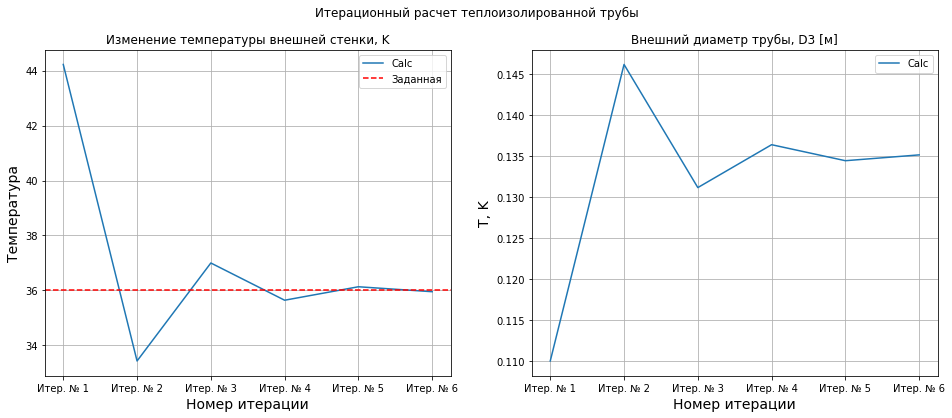

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Итерационный расчет теплоизолированной трубы')
# График 1
ax[0].set_title('Изменение температуры внешней стенки, K')
ax[0].set_ylabel('Температура', fontsize=14)
ax[0].set_xlabel('Номер итерации', fontsize=14)
ax[0].plot(metrics['Температура внешней поверхности стенки'], label = 'Calc')
ax[0].axhline(y = tw3, color = 'red', linestyle = '--', label = 'Заданная') 
# График 2
ax[1].set_title('Внешний диаметр трубы, D3 [м]')
ax[1].set_ylabel('T, K', fontsize=14)
ax[1].set_xlabel('Номер итерации', fontsize=14)
ax[1].plot(metrics['Внешний диаметр трубы'], label = 'Calc')
[[ax.legend(), ax.grid(True)] for ax in ax]
plt.show()